Changing user: . to OK
Adding user: BeneWiestler
Adding user: .
Ignoring user: Cosmin
Adding user: JSK
Adding user: Philipp Raffler
Adding user: C.Berberich
Adding user: Dr. cranky_mclean
Adding user: Su Hwan Kim
Adding user: Walder
Adding user: Schramm
Adding user: J.Schmitt
Adding user: Dr. cotothera
Adding user: Ro
Adding user: LS
Adding user: OK
Adding user: Dr. Anonymous
Adding user: Mirjam
Selected users: ['BeneWiestler', '.', 'JSK', 'Philipp Raffler', 'C.Berberich', 'Dr. cranky_mclean', 'Su Hwan Kim', 'Walder', 'Schramm', 'J.Schmitt', 'Dr. cotothera', 'Ro', 'LS', 'OK', 'Dr. Anonymous', 'Mirjam']
3.0
3.0
3.0
2.0
4.0
5.0
4.0
4.0
4.0
4.0
3.5
4.0
3.0
3.0
3.0
3.0


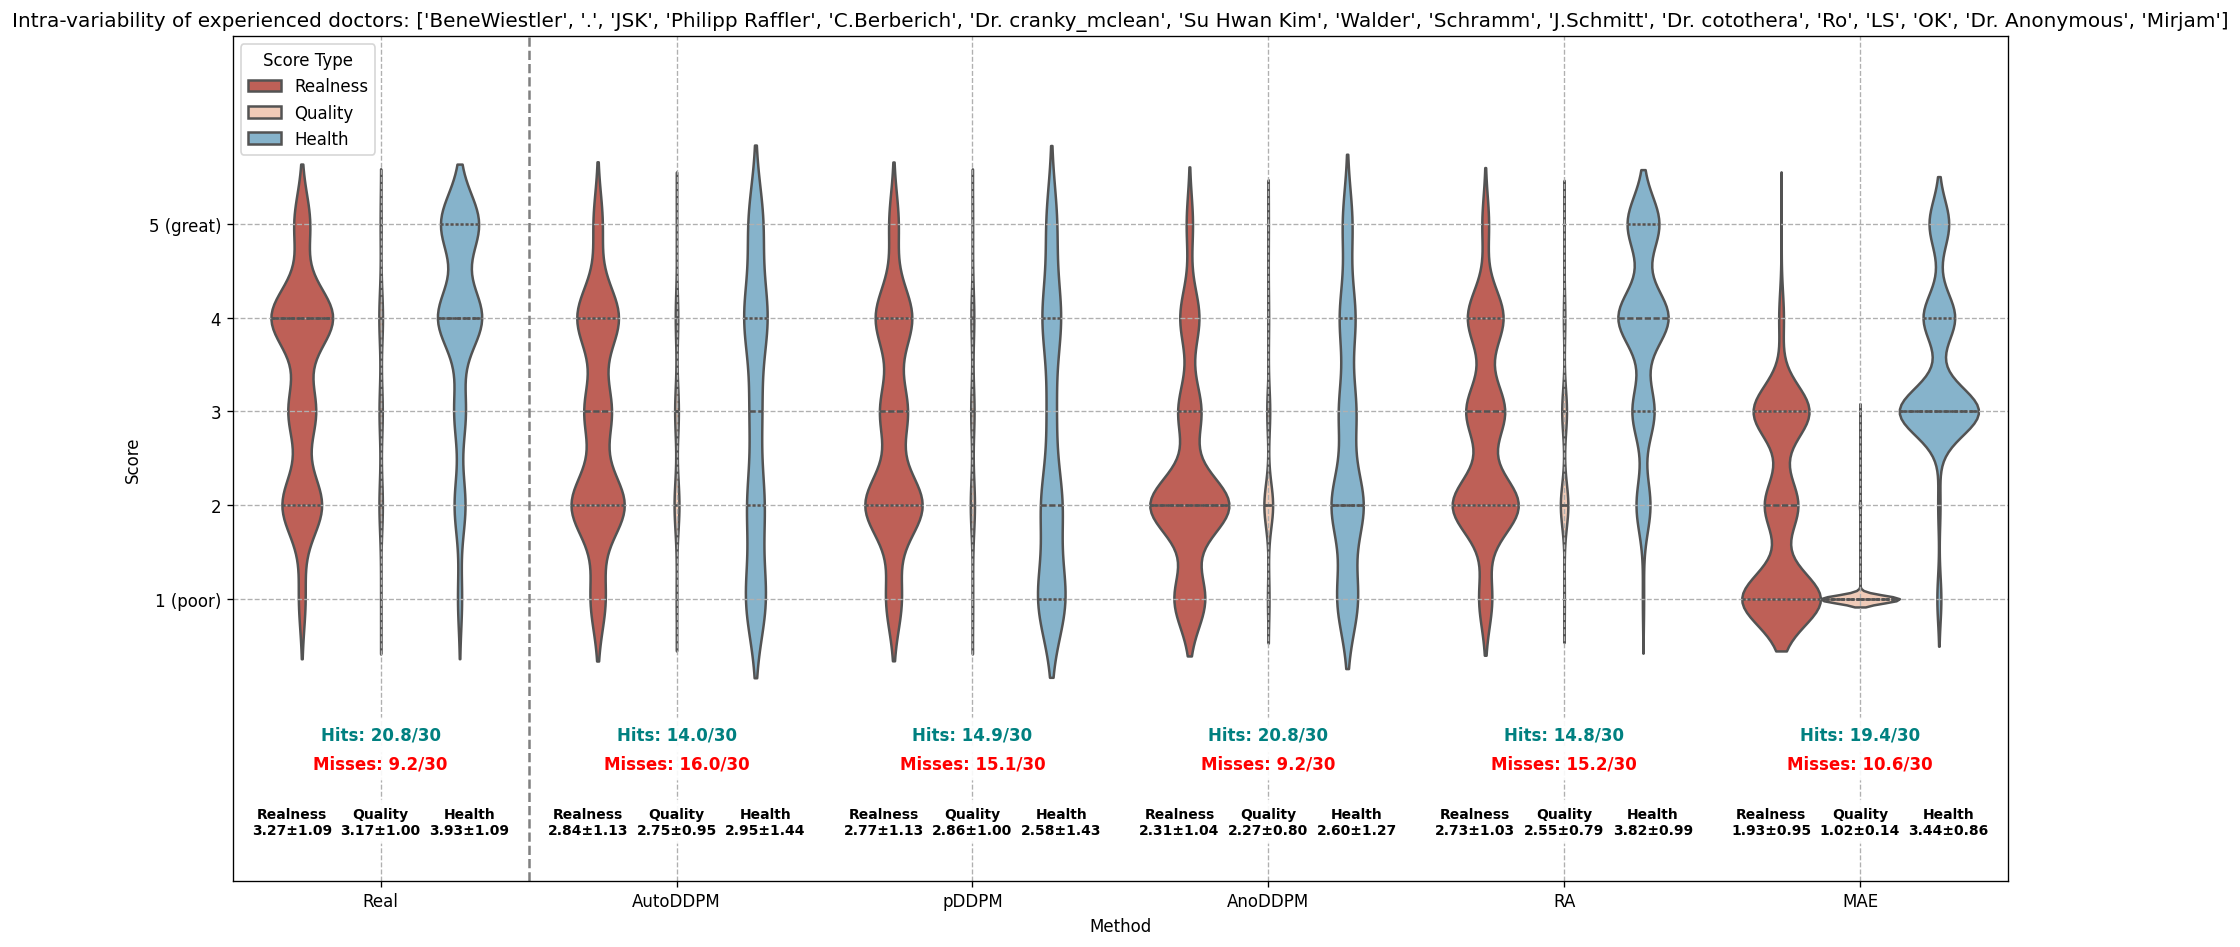

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load JSON data from the file
file_path = './radiology_data.json'

# Open the file and load the content
with open(file_path) as file:
    data = json.load(file)

## REMOVE DUPLICATES
unique_users = []
for user in data:
    user_name = user['username']
    if user_name in unique_users:
        user['username'] = 'OK'
        new_user_name = user['username']
        print(f'Changing user: {user_name} to {new_user_name}')
    unique_users.append(user_name)

mean_visu = False
userlist = ['BeneWiestler', '.', 'JSK', 'Philipp Raffler', 'C.Berberich', 'Dr. cranky_mclean', 'Su Hwan Kim', 'Walder', 'Schramm', 'J.Schmitt', 'Dr. cotothera', 'Ro', 'LS', 'OK', 'Dr. Anonymous', 'Mirjam']
# userlist = ['BeneWiestler', 'JSK']
# userlist = ['.', 'Philipp Raffler', 'C.Berberich', 'Dr. cranky_mclean', 'Su Hwan Kim', 'Walder', 'Schramm', 'J.Schmitt', 'Dr. cotothera', 'Ro', 'LS',  'Dr. Anonymous', 'Mirjam']
# userlist = ['BeneWiestler', 'JSK', 'OK']
# userlist = ['Mirjam']

data_per_user = dict()
selected_users = []
for user in data:
    user_name = user['username']
    if user_name not in userlist:
        print(f'Ignoring user: {user_name}')
        continue
    if user_name in selected_users:
        user_name = user_name + '_the_second'
    selected_users.append(user_name)
    print(f'Adding user: {user_name}')
   
    user_data = user['responses']
    # Organize data by method and calculate scores
    method_scores = {}
    for response in user_data:
        # Extract method from the filename
        filename = response['Filename']
        method = filename.split('/')[-1].split('_')[0]
        if 'Original' in method: 
            method = 'Real'
        
        if method not in method_scores:
            method_scores[method] = {'Realness': [], 'Quality': [], 'Health': []}
        
        method_scores[method]['Realness'].append(response['Realness'])
        method_scores[method]['Quality'].append(response['Quality'])
        method_scores[method]['Health'].append(response['Health'])


    # Convert the dictionary into a DataFrame for plotting
    score_list = []
    for method, scores in method_scores.items():
        for score_type, values in scores.items():
            for value in values:
                score_list.append({'Method': method, 'Score Type': score_type, 'Value': value})

    df_scores = pd.DataFrame(score_list)
    data_per_user[user_name] = df_scores
print(f'Selected users: {selected_users}')
title = 'Inter-variability of ' if mean_visu else 'Intra-variability of ' 
title += 'experienced ' if 'JSK' in selected_users else 'resident '
title = title + 'doctors: ' + str(selected_users)


# Specify the order of the methods
order = ["Real", "AutoDDPM", "pDDPM", "AnoDDPM", "RA", "MAE"]

# Calculate and annotate the mean and std for each group
stats_per_user = dict()
lowest_point = 100
highest_point = 0
for key in data_per_user.keys():
    stats_per_user[key] = dict()
    df_scores = data_per_user[key]
    real_mean = -1
    foolingness = dict()
    lowest_point = df_scores['Value'].min() if lowest_point > df_scores['Value'].min() else lowest_point  # lower by 1 to avoid overlap
    highest_point = df_scores['Value'].max() if highest_point < df_scores['Value'].max() else highest_point  # higher by 1 to avoid overlap

    for i, method in enumerate(order):
        stats_per_user[key][method] = dict()
        for j, score_type in enumerate(['Realness', 'Quality', 'Health']):
            score_values = df_scores[(df_scores['Method'] == method) & (df_scores['Score Type'] == score_type)]['Value']
            stats_per_user[key][method][score_type] = score_values
            # mean = np.mean(score_values)
            # std = np.std(score_values)
            # Annotate under the plot
            if score_type == 'Realness':
                if method == 'Real': 
                    real_mean = np.percentile(score_values * 1.0, 50)
                    print(real_mean)
                foolme = np.sum(score_values>=3) # set to real_mean if you want relative scores
                stats_per_user[key][method]['Foolness'] = foolme 
method_scores = dict()
for method in order:
    if method not in method_scores:
        method_scores[method] = {'Realness': [], 'Quality': [], 'Health': []}
    
    for key in stats_per_user.keys():
        if mean_visu: 
            method_scores[method]['Realness'].append(np.mean(stats_per_user[key][method]['Realness']))
            method_scores[method]['Quality'].append(np.mean(stats_per_user[key][method]['Quality']))
            method_scores[method]['Health'].append(np.mean(stats_per_user[key][method]['Health']))
        else: 
            method_scores[method]['Realness'].extend(stats_per_user[key][method]['Realness'])
            method_scores[method]['Quality'].extend(stats_per_user[key][method]['Quality'])
            method_scores[method]['Health'].extend(stats_per_user[key][method]['Health'])


# Convert the dictionary into a DataFrame for plotting
plt.rcParams.update({'font.size': 10})

score_list = []
for method, scores in method_scores.items():
    for score_type, values in scores.items():
        for value in values:
            score_list.append({'Method': method, 'Score Type': score_type, 'Value': value})

df_scores = pd.DataFrame(score_list)
    # Create violin plot
pallete_rbgu = sns.color_palette("RdBu", n_colors=10)
pallete_ = [pallete_rbgu[1], pallete_rbgu[3], pallete_rbgu[7]]
plt.figure(figsize=(16, 8), dpi=120)  # Increased figure size and resolution
ax = sns.violinplot(data=df_scores, x='Method', y='Value', hue='Score Type', inner='quart',
            linewidth=1.5, order=order, palette=pallete_)

plt.title(title)
plt.xlabel('Method')
plt.ylabel('Score')
plt.legend(title='Score Type', loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--')
plt.yticks([1,2,3,4,5], ['1 (poor)', '2', '3', '4', '5 (great)'])  # Set custom y-ticks

# Adding a vertical line to separate Original from other methods
plt.axvline(0.5, color='grey', linestyle='--')    
for i, method in enumerate(order):
    for j, score_type in enumerate(['Realness', 'Quality', 'Health']):
        score_values = []
        fool_values = []
        for key in stats_per_user.keys():
            score_values_user = stats_per_user[key][method][score_type]
            if mean_visu:
                score_values.append(np.mean(score_values_user))
            else:
                score_values.append(score_values_user)
            fool_values_user = stats_per_user[key][method]['Foolness']
            fool_values.append(fool_values_user)
        # Annotate under the plot
        
        mean = np.mean(score_values)
        std = np.std(score_values)
        if score_type == 'Realness': 
            if method == 'Real':
                plt.text(i, df_scores['Value'].min() - 1.5, f'Hits: {np.mean(fool_values):.1f}/30', horizontalalignment='center', 
                         color='teal', weight='semibold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))
                plt.text(i, df_scores['Value'].min() - 1.8, f'Misses: {30 - np.mean(fool_values):.1f}/30', horizontalalignment='center', 
                         color='red', weight='semibold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))

            else:
                plt.text(i, df_scores['Value'].min() - 1.5, f'Hits: {30 - np.mean(fool_values):.1f}/30', horizontalalignment='center',
                          color='teal', weight='semibold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))
                plt.text(i, df_scores['Value'].min() - 1.8, f'Misses: {np.mean(fool_values):.1f}/30', horizontalalignment='center',
                          color='red', weight='semibold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))

        plt.text(i + (j - 1) * 0.3, -1.5, f'{score_type}\n{mean:.2f}±{std:.2f}', 
                horizontalalignment='center', size='small', color='black', weight='semibold', bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.5'))

plt.ylim(lowest_point - 3, highest_point + 2)  # Set y-axis limits to make space for text

plt.tight_layout()
plt.show()